### Stereo vision
version 6

See for model 
https://pytorch.org/vision/stable/models/mask_rcnn.html

https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.maskrcnn_resnet50_fpn

See for visualisation https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py


In [188]:
import copy
import math


import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights,MaskRCNN_ResNet50_FPN_V2_Weights
# from torchvision.models.quantization import ResNet50_QuantizedWeights
# from torchvision.utils import make_grid
# from torchvision.io import read_image
from pathlib import Path
# from torchvision.utils import draw_bounding_boxes
# from torchvision.utils import draw_segmentation_masks
# from torchvision.utils import make_grid
# from torchvision.io import read_image
# from pathlib import Path

# import stereo_image_utils

In [189]:
# here are some helper functions
#load image from file
# preprocess image for input into mask rcnn model
# display image
# display image pair, to display two images

def load_img(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

def display_image(image):
    fig, axes = plt.subplots(figsize=(12, 8))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(image)

    plt.show()

    
def display_image_pair(first_image, second_image):
    #this funciton from Computer vision course notes 
    # When using plt.subplots, we can specify how many plottable regions we want to create through nrows and ncols
    # Here we are creating a subplot with 2 columns and 1 row (i.e. side-by-side axes)
    # When we do this, axes becomes a list of length 2 (Containing both plottable axes)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    
    # TODO: Call imshow on each of the axes with the first and second images
    #       Make sure you handle both RGB and grayscale images
    if first_image.ndim == 2:
        axes[0].imshow(first_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[0].imshow(first_image)

    if second_image.ndim == 2:
        axes[1].imshow(second_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[1].imshow(second_image)

    plt.show()


In [190]:
# these colours are used to draw boxes.

COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

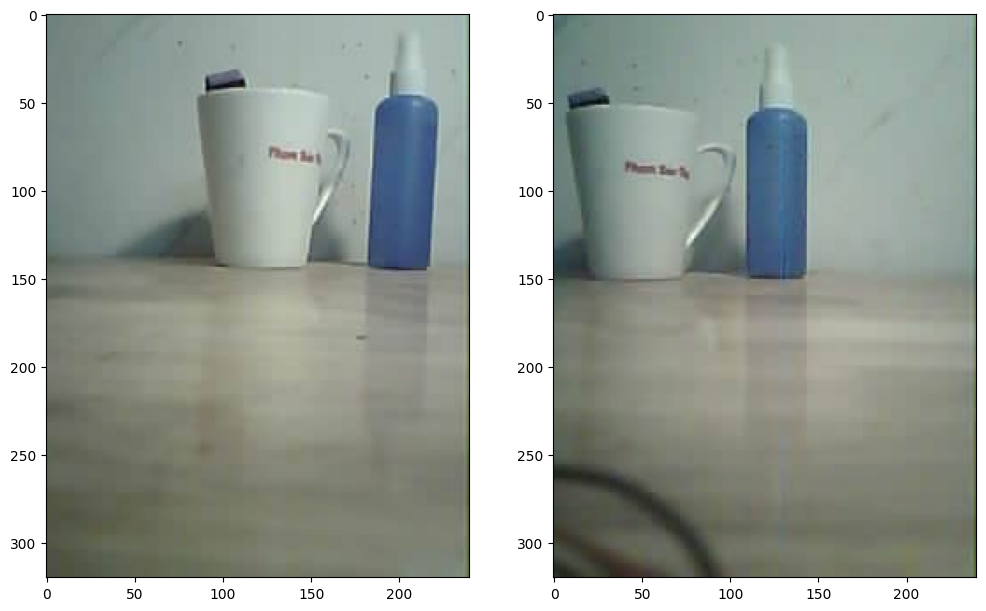

(320, 240, 3)


In [191]:
# I have two images, a left an a right image with my iphone camera. I am holding the camera with my hand
# so it is not an exact grid

d_calib = "custom"

path = "C:/Users/phamd/Dev/Vissup_smart_glasses/train_models/esp32_stereo_camera/python_notebooks/"

# left_eye = path + 'left_eye_' + d_calib + '.jpg'  # 'left_eye_demo2.jpg'
# right_eye = path + 'right_eye_' + d_calib + '.jpg'  # 'right_eye_demo2.jpg'
left_eye = f"left_{d_calib}.jpg"
right_eye = f"right_{d_calib}.jpg"

# down sample image to get same size as expected from esp32 cam


left_img = load_img(left_eye)
# left_img = cv2.resize(left_img, dsize=(sz1,sz2), interpolation=cv2.INTER_LINEAR)

right_img = load_img(right_eye)
# right_img = cv2.resize(right_img, dsize=(sz1,sz2), interpolation=cv2.INTER_LINEAR)

sz1 = right_img.shape[1]
sz2 = right_img.shape[0]

display_image_pair(left_img, right_img)

imgs = [left_img, right_img]

left_right = [preprocess_image(d).squeeze(dim=0) for d in imgs]

print(right_img.shape)

## do object detection with MaskRCNN network.

In [192]:
# we use the default weights and set up the model

weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)
_ = model.eval()

In [193]:
# this functions returns the detections
# det is the boxes, top left and bottom right cooridinates
# lbls are the class labels
# scores are the confidence. We use 0.5 as default
# masks are the segmentation masks.

def get_detections(maskrcnn, imgs, score_threshold=0.3): #person, dog, elephan, zebra, giraffe, toilet
    ''' Runs maskrcnn over all frames in vid, storing the detections '''
    # Record how long the video is (in frames)
    det = []
    lbls = []
    scores = []
    masks = []
    
    for img in imgs:
        with torch.no_grad():
            result = maskrcnn(preprocess_image(img))[0]
    
        mask = result["scores"] > score_threshold

        boxes = result["boxes"][mask].detach().cpu().numpy()
        det.append(boxes)
        lbls.append(result["labels"][mask].detach().cpu().numpy())
        scores.append(result["scores"][mask].detach().cpu().numpy())
#         masks.append(result["masks"][mask].detach().cpu().numpy())
        masks.append(result["masks"][mask]) #I want this as a tensor
        
    # det is bounding boxes, lbls is class labels, scores are confidences and masks are segmentation masks
    return det, lbls, scores, masks

#det[0] are the bounding boxes in the left image
#det[1] are the bounding boxes in the right image

In [194]:
det, lbls, scores, masks = get_detections(model,imgs)

In [195]:
print(np.array(weights.meta["categories"])[lbls[0]])
print(np.array(weights.meta["categories"])[lbls[1]])

['cup' 'bottle']
['bottle' 'chair' 'cup']


### Do some visualisation

In [196]:
#draws the bounding boxes
def draw_detections(img, det, colours=COLOURS, obj_order = None):
    for i, (tlx, tly, brx, bry) in enumerate(det):
        if obj_order is not None and len(obj_order) < i:
            i = obj_order[i]
        i %= len(colours)
        c = colours[i]
        
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)


#annotate the class labels
def annotate_class(img, det, lbls, conf=None, colours=COLOURS, class_map=weights.meta["categories"]):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[lbls[i]]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the 
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1
        
        cv2.rectangle(img, 
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)
        
        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)


def draw_instance_segmentation_mask(img, masks):
    ''' Draws segmentation masks over an img '''
    seg_colours = np.zeros_like(img, dtype=np.uint8)
    for i, mask in enumerate(masks):
        col = (mask[0, :, :, None] * COLOURS[i])
        seg_colours = np.maximum(seg_colours, col.astype(np.uint8))
    cv2.addWeighted(img, 0.75, seg_colours, 0.75, 1.0, dst=img)    
    


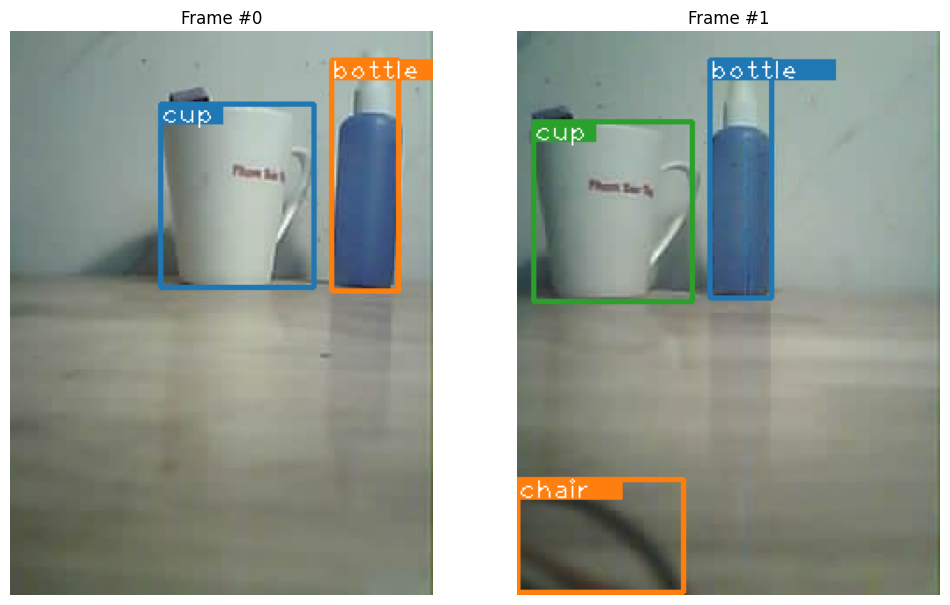

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# imgs1 = imgs.copy()

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti)
    masksi = masks[i].detach().cpu().numpy()
    annotate_class(img,deti,lbls[i])
#     draw_instance_segmentation_mask(img, masksi)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')

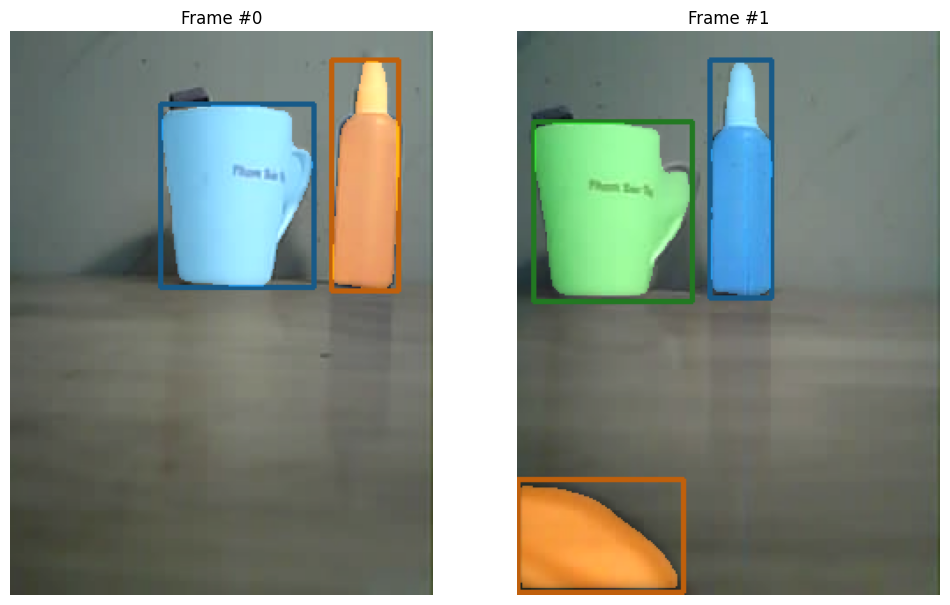

In [198]:
#draw with masks

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# imgs2 = imgs.copy()

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti)
    masks[i][masks[i]<0.7]=0
    masksi = masks[i].detach().cpu().numpy()
#     annotate_class(img,deti,lbls[i])
    draw_instance_segmentation_mask(img, masksi)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')

In [199]:
#get centr, top left and bottom right of boxes

def tlbr_to_center1(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+brx)/2
        cy = (tly+bry)/2
        points.append([cx, cy])
    return points

def tlbr_to_corner(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+tlx)/2
        cy = (tly+tly)/2
        points.append((cx, cy))
    return points

def tlbr_to_corner_br(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx+brx)/2
        cy = (bry+bry)/2
        points.append((cx, cy))
    return points

def tlbr_to_area(boxes):
    areas = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx-tlx)
        cy = (bry-tly)
        areas.append(abs(cx*cy))
    return areas



In [200]:
#get all distances from every object box to every other object box
#left image is boxes[0]
#right image is boxes[1]

#do broad casting.
#in python, col vector - row vector gives matrix:
# [a] - [c,d] = [a-c, a-d]
# [b]           [b-c, b-d]

def get_horiz_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_tl(boxes):
    pnts1 = np.array(tlbr_to_corner(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_br(boxes):
    pnts1 = np.array(tlbr_to_corner_br(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner_br(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_vertic_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,1]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,1]
    return pnts1[:,None] - pnts2[None]

def get_area_diffs(boxes):
    pnts1 = np.array(tlbr_to_area(boxes[0]))
    pnts2 = np.array(tlbr_to_area(boxes[1]))
    return abs(pnts1[:,None] - pnts2[None])


In [201]:
## get distance bentween corner and centre

centre = sz1/2

def get_dist_to_centre_tl(box, cntr = centre):
    pnts = np.array(tlbr_to_corner(box))[:,0]
    return abs(pnts - cntr)


def get_dist_to_centre_br(box, cntr = centre):
    pnts = np.array(tlbr_to_corner_br(box))[:,0]
    return abs(pnts - cntr)



In [202]:
tmp1 = get_dist_to_centre_br(det[0])
tmp2 = get_dist_to_centre_br(det[1])
print(tmp1)
print(tmp2)

[ 52.98649597 100.82829285]
[24.74655151 25.93144226 20.12676239]


In [203]:
#create the tracking cost function.
#consists of theree parts.
#  1. The vertical move up and down of object centre of mass. Scale this up because we do not expect this to be very much.
#  2. The move left or right by the object. We only expect it to move right (from the left eye image). So penalise if it moves left.
#  3. The difference in area of pixels. Area of image is width x height, so divide by height, there for this will have max value of width

def get_cost(boxes, lbls = None, sz1 = 400):
    alpha = sz1; beta  = 10; gamma = 5
    
    #vertical_dist, scale by gamma since can't move up or down
    vert_dist = gamma*abs(get_vertic_dist_centre(boxes))
    
    #horizonatl distance.
    horiz_dist = get_horiz_dist_centre(boxes)
    
    #increase cost if object has moved from right to left.
    horiz_dist[horiz_dist<0] = beta*abs(horiz_dist[horiz_dist<0])
    
    #area of box
    area_diffs = get_area_diffs(boxes)/alpha
    
    cost = np.array([vert_dist,horiz_dist,area_diffs])
    
    cost=cost.sum(axis=0)
    
    #add penalty term for different object classes
    if lbls is not None:
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                if (lbls[0][i]!=lbls[1][j]):
                    cost[i,j]+=150
    return cost
   


In [204]:
#get cost with centre of mass

In [205]:
def get_cost_with_com(masks, lbls = None,prob_thresh = 0.7):
    alpha = 240; beta  = 10; gamma = 5

    #left masks
    mask_bool = masks[0] > prob_thresh
    mask_bool = mask_bool.squeeze(1)
    #right masks
    mask_bool2 = masks[1] > prob_thresh
    mask_bool2 = mask_bool2.squeeze(1)
    
    #left params
    #com1 is center of mass of height
    #com2 is center of mass of width
    mask_size = (mask_bool).sum(dim=[1,2])
    mask_com_matrix_1 = torch.tensor(range(mask_bool.shape[1]))
    com1 = ((mask_com_matrix_1.unsqueeze(1))*mask_bool).sum(dim=[1,2])/mask_size
    mask_com_matrix_2 = torch.tensor(range(mask_bool.shape[2]))
    com2 = ((mask_com_matrix_2.unsqueeze(0))*mask_bool).sum(dim=[1,2])/mask_size

    left_params = torch.stack((com1, com2, mask_size)).transpose(1,0)
    
    #get right params
    mask_size2 = (mask_bool2).sum(dim=[1,2])
    mask_com_matrix_12 = torch.tensor(range(mask_bool2.shape[1]))
    com12 = ((mask_com_matrix_12.unsqueeze(1))*mask_bool2).sum(dim=[1,2])/mask_size2
    mask_com_matrix_22 = torch.tensor(range(mask_bool2.shape[2]))
    com22 = ((mask_com_matrix_22.unsqueeze(0))*mask_bool2).sum(dim=[1,2])/mask_size2

    right_params = torch.stack((com12, com22, mask_size2)).transpose(1,0)
    
    #calculate cost function
    cost = (left_params[:,None] - right_params[None])
    #scale counts
    cost[:,:,2]=abs(cost[:,:,2])/alpha

    #can't move right, can only move left
    cost[cost[:,:,1]<0] = beta*abs(cost[cost[:,:,1]<0])

    #move up and down, take abs vals
    cost[:,:,0] = gamma*abs(cost[:,:,0])
    # print(cost.shape)
    cost = cost.sum(dim=2)
    if lbls is not None:
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                if (lbls[0][i]!=lbls[1][j]):
                    cost[i,j]+=100
#                     print(lbls[0][i], lbls[1][j])
    return cost
   
    
def get_horiz_dist(masks, prob_thresh = 0.7):
    # gets the horizontal distance between the centre of mass for each object
    #left masks
    mask_bool = masks[0] > prob_thresh
    mask_bool = mask_bool.squeeze(1)
    #right masks
    mask_bool2 = masks[1] > prob_thresh
    mask_bool2 = mask_bool2.squeeze(1)
    
    #left params
    #com1 is center of mass of height
    #com2 is center of mass of width
    mask_size = (mask_bool).sum(dim=[1,2])
    mask_com_matrix_1 = torch.tensor(range(mask_bool.shape[1]))
    com1 = ((mask_com_matrix_1.unsqueeze(1))*mask_bool).sum(dim=[1,2])/mask_size
    mask_com_matrix_2 = torch.tensor(range(mask_bool.shape[2]))
    com2 = ((mask_com_matrix_2.unsqueeze(0))*mask_bool).sum(dim=[1,2])/mask_size

    left_params = torch.stack((com1, com2, mask_size)).transpose(1,0)
    
    #get right params
    mask_size2 = (mask_bool2).sum(dim=[1,2])
    mask_com_matrix_12 = torch.tensor(range(mask_bool2.shape[1]))
    com12 = ((mask_com_matrix_12.unsqueeze(1))*mask_bool2).sum(dim=[1,2])/mask_size2
    mask_com_matrix_22 = torch.tensor(range(mask_bool2.shape[2]))
    com22 = ((mask_com_matrix_22.unsqueeze(0))*mask_bool2).sum(dim=[1,2])/mask_size2

    right_params = torch.stack((com12, com22, mask_size2)).transpose(1,0)
    
    #calculate cost function
    cost = (left_params[:,None] - right_params[None])
    return cost[:,:,1]

In [206]:
def get_tracks(cost):
    return scipy.optimize.linear_sum_assignment(cost)
    

def get_tracks_ij(cost):
    tracks = scipy.optimize.linear_sum_assignment(cost)
    return [[i,j] for i, j in zip(*tracks)]



In [207]:
cost = get_cost(det, lbls = lbls)

In [208]:
tracks = scipy.optimize.linear_sum_assignment(cost)
print(tracks)

h_d = [[np.array(weights.meta["categories"])[lbls[0]][i],np.array(weights.meta["categories"])[lbls[1]][j]] for i, j in zip(*tracks)]
print(np.array(weights.meta["categories"])[lbls[0]])
print(h_d)

(array([0, 1], dtype=int64), array([2, 0], dtype=int64))
['cup' 'bottle']
[['cup', 'cup'], ['bottle', 'bottle']]


## the distance between the left and right centres is given by dists for each object.

##### We use the geometric formulas to calibrate the tantheta and focal lenght of the camera for 30cm and 50cm bottle and then transform the pixels differences to distance in cm's for each object in the image

In [209]:
#we take the corner that is closest to the centre. This is because the other corner might be going off the image.

dists_tl =  get_horiz_dist_corner_tl(det)
dists_br =  get_horiz_dist_corner_br(det)

final_dists = []
dctl = get_dist_to_centre_tl(det[0])
dcbr = get_dist_to_centre_br(det[0])

for i, j in zip(*tracks):
    if dctl[i] < dcbr[i]:
        final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        
    else:
        final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        

final_dists

[(75.87465286254883, 'cup'), (73.28604888916016, 'bottle')]

In [210]:
#get focal length
# for 50cm away bottle image, we had 59.069 pixels between bottle boxes 
# and for 30cm away bottle image we had 89.158 pixels between left and right bottles
fl = 35-59.069*50/89.158
print(fl)

1.8739765360371479


In [211]:
#calibrate theta. cameras are 7.05 cms apart
tantheta = (1/(50-fl))*(10.25/2)*sz1/59.069
print(tantheta)

0.4326786982030149


In [212]:
#final distances as list
fd = [i for (i,j) in final_dists]
print(fd)

[75.87465286254883, 73.28604888916016]


In [213]:
#find distance away
dists_away = (10.25/2)*sz1*(1/tantheta)/np.array(fd)+fl

In [214]:
cat_dist = []
for i in range(len(dists_away)):
    cat_dist.append(f'{np.array(weights.meta["categories"])[lbls[0]][i]} {dists_away[i]:.1f}cm')
    print(f'{np.array(weights.meta["categories"])[lbls[0]][i]} is {dists_away[i]:.1f}cm away')

cup is 39.3cm away
bottle is 40.7cm away


In [215]:
#annotate the class labels
def annotate_class2(img, det, lbls,class_map, conf=None,  colours=COLOURS):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[i]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the 
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1
        
        cv2.rectangle(img, 
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)
        
        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)



In [216]:
list(np.array(cat_dist)[(tracks[0])])

['cup 39.3cm', 'bottle 40.7cm']

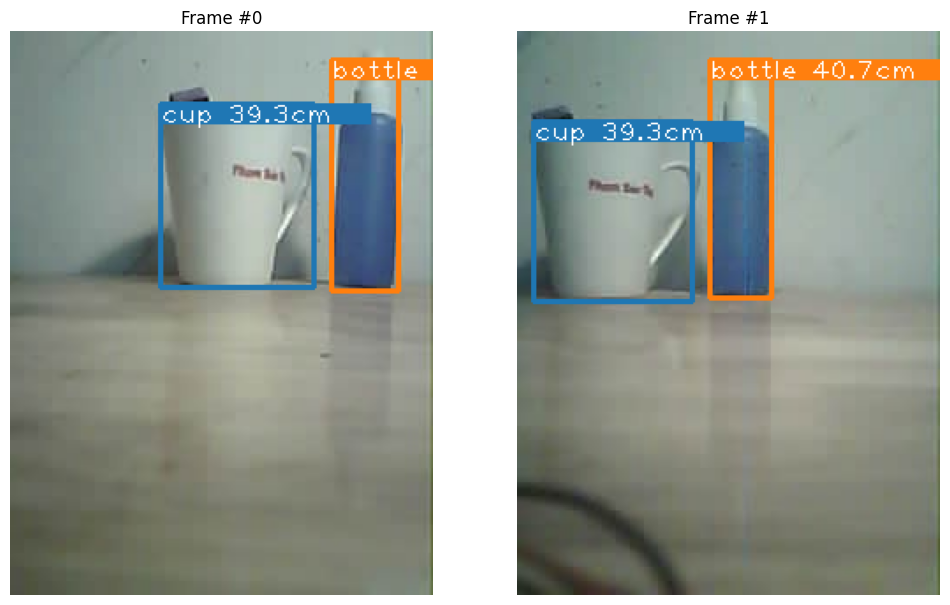

In [217]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

t1 = [list(tracks[1]), list(tracks[0])]

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti[list(tracks[i])], obj_order=list(t1[i]))
    annotate_class2(img,deti[list(tracks[i])],lbls[i][list(tracks[i])],cat_dist)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')
    